# tensorflow

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('Churn.csv')

X = pd.get_dummies(df.drop(['Churn', 'Customer ID'], axis=1))
y = df['Churn'].apply(lambda x : 1 if x=='Yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

print(X_train.head())
print(y_train.head())

In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

model = Sequential()
model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')
# sgd = stochastic gradient descent

$$H=-\frac{1}{N} \cdot \sum_{i=1}^{N} \Big(y_{i}*\log(p(y_{i})) + (1-y_{i})*\log(1 -p(y_{i}))\Big)$$

In [3]:
model.fit(X_train, y_train, epochs=300, batch_size=32)
# batch size defines the number of samples that will be propagated through the network

In [4]:
def predict():
    y_hat = model.predict(X_test)
    y_hat = [0 if val<0.5 else 1 for val in y_hat]
    print(accuracy_score(y_test, y_hat))
predict()

0.765791341376863


In [5]:
model.save('tfmodel')

INFO:tensorflow:Assets written to: tfmodel/assets


In [6]:
del model
model = load_model('tfmodel')
predict()

0.765791341376863


# pytorch

In [7]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as func
import matplotlib.pyplot as plt

In [8]:
size_of_batch = 64

In [9]:
transform = torchvision.transforms.Compose([ToTensor()])
train_tmp = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
validation_tmp = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

In [10]:
train_data = torch.utils.data.DataLoader(train_tmp, size_of_batch)
validation_data = torch.utils.data.DataLoader(validation_tmp, size_of_batch)

Dataset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
First datapoint:  (tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
  

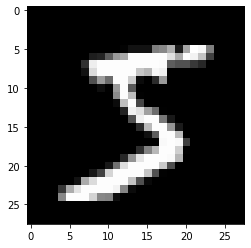

In [11]:
print('Dataset: ', train_tmp)
print('First datapoint: ', train_tmp[0])
print('Label for first datapoint: ', train_tmp[0][1])
print('Image tensor: ', train_tmp[0][0][0])
print('Image:')
plt.imshow(train_tmp[0][0][0], cmap='gray')

In [12]:
# LeNet is a convolutional neural network
def create_lenet():
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),

        nn.Flatten(), # to one dimensional tensor
        nn.Linear(in_features=400, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=10)
    )

In [13]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0') if is_cuda_available else torch.device('cpu')
print('Device is', device)

Device is cpu


In [14]:
def validate(cnn_model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        # each group size is size_of_batch
        images = images.cuda() if is_cuda_available else images
        results = cnn_model(images)
        _, indexes = torch.max(results, 1)
        indexes = indexes.data.cpu() if is_cuda_available else indexes
        total += indexes.size(0)
        correct += torch.sum(indexes == labels)
    return correct * 100. / total

In [15]:
import copy
def train(num_epoch=3, lr=1e-3, available_device=torch.device('cpu')):
    accuracies = []
    cnn = create_lenet().to(available_device)
    cel = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0.0
    best_model = cnn
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_data):
            images = images.to(available_device)
            labels = labels.to(available_device)
            optimizer.zero_grad()
            results = cnn(images)
            loss = cel(results, labels)
            loss.backward()
            optimizer.step()
        cur_accuracy = validate(cnn, validation_data)
        accuracies.append(cur_accuracy)
        if cur_accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = cur_accuracy
            print('Saving best model with accuracy: {0}%'.format(cur_accuracy))
        print('Epoch: {0}'.format(epoch + 1))
        print('Accuracy: {0}%'.format(cur_accuracy))
    print('Learning plot:')
    plt.plot(accuracies)
    return best_model

Saving best model with accuracy: 95.75%
Epoch: 1
Accuracy: 95.75%
Saving best model with accuracy: 97.37000274658203%
Epoch: 2
Accuracy: 97.37000274658203%
Saving best model with accuracy: 97.87999725341797%
Epoch: 3
Accuracy: 97.87999725341797%
Epoch: 4
Accuracy: 97.83999633789062%
Saving best model with accuracy: 98.05000305175781%
Epoch: 5
Accuracy: 98.05000305175781%
Saving best model with accuracy: 98.08999633789062%
Epoch: 6
Accuracy: 98.08999633789062%
Epoch: 7
Accuracy: 97.8499984741211%
Saving best model with accuracy: 98.2300033569336%
Epoch: 8
Accuracy: 98.2300033569336%
Epoch: 9
Accuracy: 98.16000366210938%
Epoch: 10
Accuracy: 98.18000030517578%
Learning plot:


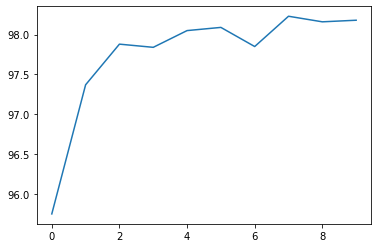

In [24]:
best_lenet_model = train(10, available_device=device)

In [25]:
import numpy as np
def predict_results(cnn_model, data):
    got_results = []
    expected_results = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda() if is_cuda_available else images
        results = cnn_model(images)
        _, indexes = torch.max(results, 1)
        indexes = indexes.data.cpu() if is_cuda_available else indexes
        got_results.extend(list(indexes.numpy()))
        expected_results.extend(list(labels.numpy()))
    return np.array(got_results), np.array(expected_results)

In [26]:
y_pred, y_true = predict_results(best_lenet_model, validation_data)

In [27]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0, 10)))

,0,1,2,3,4,5,6,7,8,9
0,973,0,3,0,0,2,1,0,1,0
1,0,1129,0,1,0,1,2,0,2,0
2,1,3,1026,0,2,0,0,0,0,0
3,0,0,4,994,1,6,0,2,2,1
4,0,0,0,0,975,0,4,1,0,2
5,2,0,0,8,0,881,1,0,0,0
6,6,2,2,0,1,28,917,0,2,0
7,1,3,12,1,0,0,0,1007,1,3
8,4,0,4,3,2,12,0,2,945,2
9,1,2,1,4,11,5,1,6,2,976


In [28]:
def prepare_image(img_url):
    data = requests.get(img_url)
    img = Image.open(BytesIO(data.content)).convert(mode="L").resize((28, 28))
    img = (255 - np.array(img)) / 255
    return img

In [29]:
import requests
from PIL import Image
from io import BytesIO
def test_some_url_image(img_url, cnn_model, available_device):
    img = prepare_image(img_url)
    with torch.no_grad():
        answer = cnn_model(torch.unsqueeze(transform(img), 0).float().to(available_device))
        return func.softmax(answer, dim=1).cpu().numpy()

Loaded image:


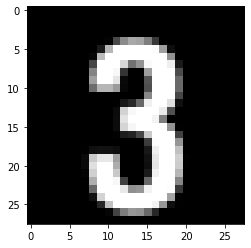

In [30]:
img_url = 'https://444444.pro/upload/iblock/01f/01f364377825ec75dc3d95464a765f47.jpg'
print('Loaded image:')
plt.imshow(prepare_image(img_url), cmap='gray')

In [31]:
results = test_some_url_image(img_url, best_lenet_model, device)
predicted_index = np.argmax(results)
print("Answer: {0}".format(predicted_index))
print("Probability: {0}%".format(results[0][predicted_index] * 100))

Answer: 3
Probability: 99.98934268951416%


# theory

$\text{Convolutional neural network} \longrightarrow \text{Good for image recognition}$
        
$\text{Long short-term memory network} \longrightarrow \text{Good for speech recognition}$

### ML Models:
        
1. Supervised Learning
    - Regression
        - Linear
            - Multiple Linear
            - Polynomial
        - Decision Tree (*)
        - Random Forests (*)
        - Neural Network (*)
    - Classification
        - Logistic Regression
        - Support Vector Machine (Hyperplane)
        - Naive Bayes
        - All from (*)
2. Unsupervised Learning
    - Clustering
        - K-means
        - Hierarchical
        - Mean shift
        - Density-based
    - Dimensionality Reduction
        - Feature Elimination
        - Feature Extraction